# Model Evaluation
This notebook evaluates the finetuned model on our test set by inspecting part-of-speech, count frequencies, and model temperature, and compares performance to a naive unsupervised GPT-2 model.
## Song Lyric Generation with GPT-2
**Data Mining Final Project**<br>
Khyatee Desai<br>Dec. 19, 2022


In [3]:
# !pip install transformers
# !pip install torch
# !pip install stop_words

In [4]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt 
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline
import statistics
from nltk.translate.bleu_score import sentence_bleu
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

In [5]:
# read in the test set
test = pd.read_parquet('Data/testing_lyrics.parquet').reset_index(drop=True)
test.head()

,lyrics
0,"Don't let me down, don't let me down Don't let..."
1,I get high when I see you go by My oh my When ...
2,[All too much!] It's all too much It's all to...
3,"I love you, 'cause you tell me things I want t..."
4,Is there anybody going to listen to my story A...


### Prep the finetuned model
We write a function to generate text with our finetuned model

In [6]:
def generate_text(model_dir, input_seq, max_length, temp):
    '''
    Encodes an input sequence and applies the finetuned model to generate predictions.'''
    
    model = GPT2LMHeadModel.from_pretrained(model_dir)
    tokenizer = GPT2Tokenizer.from_pretrained(model_dir)
    encoded = tokenizer.encode(f'{input_seq}', return_tensors='pt')
    final_outputs = model.generate(encoded,
                                do_sample=True,
                                max_length = max_length,
                                pad_token_id = model.config.eos_token_id,
                                top_k = 50,
                                top_p =0.95, 
                                temperature = temp)
    generated = tokenizer.decode(final_outputs[0], skip_special_tokens=True)
    return(generated)

### Create a naive model
We instantiate a "naive" model, which is the untrained version of GPT-2

In [81]:
naive_model = pipeline('text-generation', model='gpt2-medium')

# Test out the naive model with a sample prompt
naive_model("Hello, my name is", max_length=30, num_return_sequences=1)[0]['generated_text']


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Hello, my name is Nana and I'm a singer-songwriter, playa artist, and comic. I've known a number of bands"

## Generate Predictions
We use both the finetuned and naive models to generate predictions on the test set, using the first 50 tokens as input, and generating 200 output tokens. We save predictions to a parquet file, as this is time intensive.

In [7]:
test['input'] = test['lyrics'].apply(lambda x: ' '.join(x.split()[:50])) # 50 input tokens
# test['tuned_prediction'] = test['input'].apply(lambda input_text: generate_text('saved_model', input_text, 200, temp=1.0)) # generate 200 tokens with finetuned model
# test['naive_prediction'] = test['input'].apply(lambda input_text: naive_model(input_text, max_length=200, num_return_sequences=1)[0]['generated_text']) # generate 200 tokens with naive model
# test.to_parquet('predictions.parquet') # save predictions


In [38]:
# inspect the predictions generated in previous cell
preds = pd.read_parquet('Data/predictions.parquet') 
preds['lyrics_end'] = preds['lyrics'].apply(lambda x: ' '.join(x.split()[50:150])) # 100 tokens
preds['naive_prediction_end'] = preds['naive_prediction'].apply(lambda x: ' '.join(x.split()[50:150])) # 100 tokens
preds['tuned_prediction_end'] = preds['tuned_prediction'].apply(lambda x: ' '.join(x.split()[50:150])) # 100 tokens
preds.head()

,lyrics,input,tuned_prediction,naive_prediction,lyrics_end,naive_prediction_end,tuned_prediction_end
0,"Don't let me down, don't let me down Don't let...","Don't let me down, don't let me down Don't let...","Don't let me down, don't let me down Don't let...","Don't let me down, don't let me down Don't let...","let me down Don't let me down, don't let me do...",let me down I love you (more and louder) I lov...,"let me down Don't let me down, don't let me do..."
1,I get high when I see you go by My oh my When ...,I get high when I see you go by My oh my When ...,I get high when I see you go by My oh my When ...,I get high when I see you go by My oh my When ...,is all But it's so hard loving you Is it right...,all I can do Why is there not more love in you...,is all But it's so hard loving you Is it right...
2,[All too much!] It's all too much It's all to...,[All too much!] It's all too much It's all too...,[All too much!] It's all too much It's all too...,[All too much!] It's all too much It's all too...,"Everywhere, it's what you make For us to take,...",seems to be gone forever Now I'm just another ...,"Everywhere, it's what you make For us to take,..."
3,"I love you, 'cause you tell me things I want t...","I love you, 'cause you tell me things I want t...","I love you, 'cause you tell me things I want t...","I love you, 'cause you tell me things I want t...","the reason why If I cry, it's not because I'm ...",And never ever forget that I'm my own mother O...,I Would give everything I've got For a little ...
4,Is there anybody going to listen to my story A...,Is there anybody going to listen to my story A...,Is there anybody going to listen to my story A...,Is there anybody going to listen to my story A...,so hard to leave her She will turn to me and s...,"to forget. Ah, girl when I think of all the ti...",so hard to leave her She will turn to me and s...


# Evaluation
We use several methods to assess the quality of generated predictions, and compare them to those of a naive model.

In [99]:
# Visually inspect predictions for one of the test songs
i = 17 # pick a random song
print("Model Input:\n",preds['input'][i],'\n')
print("Actual Lyrics:\n",preds['lyrics_end'][i],'\n')
print("Naive Model Predictions:\n",preds['naive_prediction_end'][i],'\n')
print("Finetuned Model Predictions:\n",preds['tuned_prediction_end'][i])

Model Input:
 Oh yeah, I'll tell you something I think you'll understand When I say that something I wanna hold your hand I wanna hold your hand I wanna hold your hand Oh please, say to me You'll let me be your man And please, say to me You'll let me hold 

Actual Lyrics:
 your hand You'll let me hold your hand I wanna hold your hand And when I touch you I feel happy Inside It's such a feeling that my love I can't hide I can't hide I can't hide Yeah, you got that something I think you'll understand When I say that something I wanna hold your hand I wanna hold your hand I wanna hold your hand And when I touch you I feel happy Inside It's such a feeling that my love I can't hide I can't hide I can't hide Yeah, you got that something I think you'll 

Naive Model Predictions:
 your hand Oh please, say to me Oh please you'll let me hold your hand Oh please I want to love you (Hook 3) I want to love you Oh how I wanna cry Oh how I wanna weep And touch your face If you'll let me be your man A

## BLEU Score
We compare model predictions to a song's actual lyrics, and compute a BLEU score to quantify how similar the generated text is to the actual text. Two identical texts will yield a BLEU score of 1, so a high BLEU score indicates that our model has "learned" during the finetuning process.

In [96]:
def tokenize(string):
    '''Removes puntuation from a string and separates it into a list of tokens'''
    return(string.lower().replace(',','').replace('(','').replace(')','').replace("?",'').split(' '))

In [97]:
# Calculate blue scores between predicted lyrics and actual lyrics
tuned_scores=[]
for i in range(len(preds)): # iterate through each test song
    reference = [tokenize(preds['lyrics_end'][i])] # list of actual lyrics
    candidate = tokenize(preds['tuned_prediction_end'][i]) # list of tuned-model-predicted lyrics
    tuned_scores.append(sentence_bleu(reference, candidate))
# put scores in a pandas dataframe
bleu_scores = pd.DataFrame(tuned_scores).rename(columns={0:'tuned'})

naive_scores=[]
for i in range(len(preds)):
    reference = [tokenize(preds['lyrics_end'][i])]
    candidate = tokenize(preds['naive_prediction_end'][i]) # list of naive-model-predicted lyrics
    naive_scores.append(sentence_bleu(reference, candidate))

# add naive scores to dataframe
bleu_scores['naive'] = naive_scores
bleu_scores

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

,tuned,naive
0,1.179519e-01,8.428038e-79
1,5.435008e-01,6.934361e-02
2,2.387070e-01,3.274880e-155
3,3.663018e-155,1.531700e-78
4,2.359876e-01,4.934581e-02
5,3.078454e-01,3.799095e-155
6,6.980296e-01,3.655267e-02
7,9.467214e-02,5.323806e-02
8,5.691642e-01,1.805356e-155
9,1.804753e-01,1.169824e-231


In [42]:
# calculate the average bleu score for each model
print('Average BLEU for tuned model predictions:',bleu_scores.tuned.mean())
print('Average BLEU for naive model predictions:',bleu_scores.naive.mean())

Average BLEU for tuned model predictions: 0.4018374913693834
Average BLEU for naive model predictions: 0.03918497577015541


We observe that the tuned model yields a higher BLEU score, and therefore generated predictions that are more similar to the actual song lyrics than the naive model.
## Parts of Speech
We inspect the frequency of different parts of speech for each prediction set to determine how it compares to the original lyrics. If our model has learned sufficiently, we should see a part-of-speech distribution in our predicted lyrics that is very similar to that of the actual lyrics.

In [43]:
# inspect our predictions
preds[['input', 'lyrics_end', 'naive_prediction_end','tuned_prediction_end']].head()

,input,lyrics_end,naive_prediction_end,tuned_prediction_end
0,"Don't let me down, don't let me down Don't let...","let me down Don't let me down, don't let me do...",let me down I love you (more and louder) I lov...,"let me down Don't let me down, don't let me do..."
1,I get high when I see you go by My oh my When ...,is all But it's so hard loving you Is it right...,all I can do Why is there not more love in you...,is all But it's so hard loving you Is it right...
2,[All too much!] It's all too much It's all too...,"Everywhere, it's what you make For us to take,...",seems to be gone forever Now I'm just another ...,"Everywhere, it's what you make For us to take,..."
3,"I love you, 'cause you tell me things I want t...","the reason why If I cry, it's not because I'm ...",And never ever forget that I'm my own mother O...,I Would give everything I've got For a little ...
4,Is there anybody going to listen to my story A...,so hard to leave her She will turn to me and s...,"to forget. Ah, girl when I think of all the ti...",so hard to leave her She will turn to me and s...


In [44]:
# concatenate all test set lyrics into a single string
all_tuned_preds_str = ' '.join(list(preds.tuned_prediction_end.str.lower()))
all_naive_preds_str = ' '.join(list(preds.naive_prediction_end.str.lower()))
all_actual_str = ' '.join(list(preds.lyrics_end.str.lower()))


In [54]:
# tokenize all test set lyrics and calculate POS frequencies for each model
# actual lyrics
tokens = tokenize(all_actual_str)
pos = nltk.pos_tag(tokens) # tag each token with its POS
actual_counts={}
for word, tag in pos:
    if tag in actual_counts:
        actual_counts[tag]+=1
    else:
        actual_counts[tag]=1
# normalize
for pos, count in actual_counts.items():
    actual_counts[pos]= count/len(tokens)

# tuned model predictions
tokens = tokenize(all_tuned_preds_str)
pos = nltk.pos_tag(tokens)
tuned_pred_counts={}
for word, tag in pos:
    if tag in tuned_pred_counts:
        tuned_pred_counts[tag]+=1
    else:
        tuned_pred_counts[tag]=1
# normalize
for pos, count in tuned_pred_counts.items():
    tuned_pred_counts[pos]= count/len(tokens)
    
# naive model predictions
tokens = tokenize(all_naive_preds_str)
pos = nltk.pos_tag(tokens)
naive_pred_counts={}
for word, tag in pos:
    if tag in naive_pred_counts:
        naive_pred_counts[tag]+=1
    else:
        naive_pred_counts[tag]=1
# normalize
for pos, count in naive_pred_counts.items():
    naive_pred_counts[pos]= count/len(tokens)

naive_pred_counts # inspect one of the dictionaries

{'VB': 0.09090909090909091,
 'PRP': 0.08253588516746412,
 'RP': 0.005681818181818182,
 'RB': 0.07685406698564594,
 'VBP': 0.07805023923444976,
 'RBR': 0.0014952153110047847,
 'CC': 0.03618421052631579,
 'JJ': 0.09001196172248804,
 'DT': 0.06668660287081339,
 'NNS': 0.02033492822966507,
 'MD': 0.010466507177033494,
 'WRB': 0.012260765550239234,
 'VBZ': 0.023624401913875596,
 'NN': 0.17942583732057416,
 'IN': 0.08074162679425838,
 'WP': 0.00687799043062201,
 'TO': 0.028110047846889953,
 'PRP$': 0.038576555023923445,
 'VBG': 0.015849282296650717,
 'VBN': 0.011961722488038277,
 'VBD': 0.024820574162679427,
 'PDT': 0.0029904306220095694,
 'CD': 0.0026913875598086126,
 'FW': 0.0029904306220095694,
 'WDT': 0.0026913875598086126,
 'SYM': 0.0002990430622009569,
 ':': 0.0008971291866028708,
 'NNP': 0.0014952153110047847,
 'JJR': 0.0020933014354066986,
 'UH': 0.0011961722488038277,
 'JJS': 0.0008971291866028708,
 'EX': 0.0002990430622009569}

In [55]:
# inspect the part of speech frequencies in a dataframe
pos_dist = pd.concat([pd.Series(actual_counts),pd.Series(tuned_pred_counts),pd.Series(naive_pred_counts)],axis=1).rename(columns={0:'actual', 1:'tuned_prediction', 2:'naive_prediction'}).sort_values('actual',ascending=False)
pos_dist

,actual,tuned_prediction,naive_prediction
NN,0.198119,0.190882,0.179426
VB,0.091019,0.073529,0.090909
PRP,0.088896,0.097059,0.082536
JJ,0.082828,0.081471,0.090012
IN,0.074333,0.077647,0.080742
VBP,0.074029,0.073529,0.078050
RB,0.069782,0.067059,0.076854
DT,0.063410,0.075588,0.066687
PRP$,0.034891,0.037059,0.038577
CC,0.033374,0.032647,0.036184


In [90]:
# visualize the pos distribution for each model alongside original lyrics
ind = np.arange(len(pos_dist))
width = .3
plt.figure(figsize=[12,7])
plt.bar(ind+.5*width, pos_dist.tuned_prediction, .3, label='Tuned Predicted Lyrics', color='teal')
plt.bar(ind-.5*width, pos_dist.naive_prediction, .3, label='Naive Predicted Lyrics', color='orange')
plt.bar(ind+1.5*width, pos_dist.actual, .3, label='Original Lyrics', color='purple')
plt.xticks(rotation=55)
plt.legend()
plt.title("Part of Speech Distribution of Lyrics")
plt.xlabel('Part of Speech')
plt.ylabel('Word Count')
plt.xticks(ind + width/2 , (pos_dist.index),rotation=55)
plt.tick_params(axis='x', which='major', labelsize=12)
# plt.show();
plt.savefig('temp/pos.png', transparent=True);

We observe that part-of-speech distribution is very similar between our tuned model and the original lyrics. However, this is also the case for the naive model, so this does not provide us with information on how well our model learned through finetuning.
## Count Frequency
We calculate the word frequencies of different words within the generated lyrics to determine which words are most popular. If our model has learned the style of Beatles lyrics through finetuning, we expect to see similar words in our most frequent words of the tuned model and the actual lyrics.

In [57]:
# make a list of stopwords
nltk_stop_words = list(stopwords.words('english'))
stop_words = list(get_stop_words('en'))
stop_words.extend(nltk_stop_words)

# remove all stopwords from the predicted/actual lyrics
all_actual_str_no_stop = [w for w in tokenize(all_actual_str) if not w in stop_words]
all_naive_preds_str_no_stop = [w for w in tokenize(all_naive_preds_str) if not w in stop_words]
all_tuned_preds_str_no_stop = [w for w in tokenize(all_tuned_preds_str) if not w in stop_words]


In [58]:
# inspect sample lyrics with and without stopwords
print("Lyrics with stopwords:\n",tokenize(all_actual_str)[:10])
print("Lyrics without stopwords:\n",all_actual_str_no_stop[:10])

Lyrics with stopwords:
 ['let', 'me', 'down', "don't", 'let', 'me', 'down', "don't", 'let', 'me']
Lyrics without stopwords:
 ['let', 'let', 'let', 'love', 'first', 'time', 'know', 'gonna', 'last', 'love']


### Plot most frequent words from predictions and actual lyrics

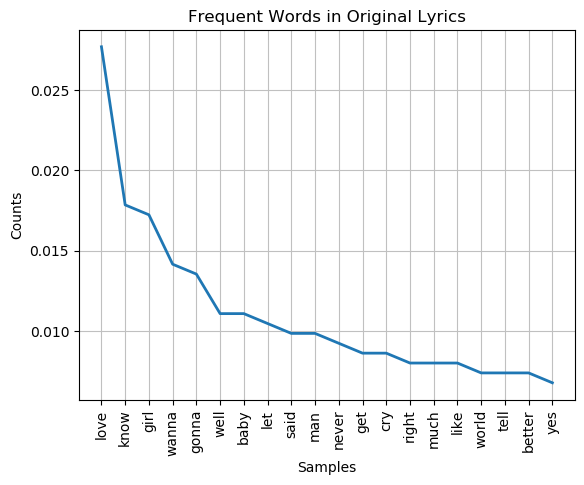

In [71]:
# plot the frequency distribution of each token in original lyrics
dist_actual = nltk.FreqDist(all_actual_str_no_stop)
for word, count in dist_actual.items():
    dist_actual[word]= count/len(all_actual_str_no_stop)
filter_words = dict([(m, n) for m, n in dist_actual.items() if len(m) > 2])
dist_actual = nltk.FreqDist(filter_words)
dist_actual.plot(20, cumulative=False);
plt.title('Frequent Words in Original Lyrics');


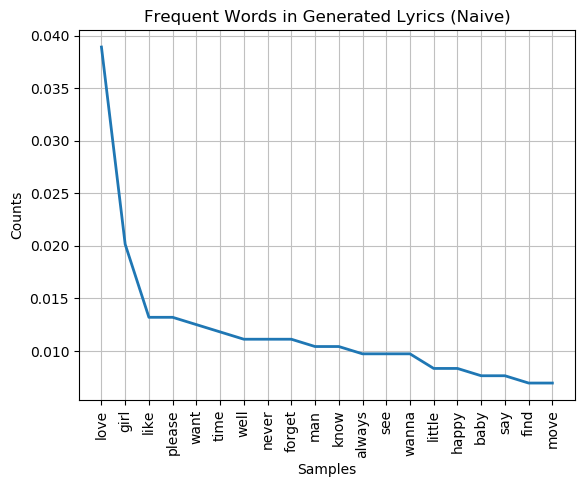

In [73]:
# plot the frequency distribution of each token in naive model lyrics
dist_naive = nltk.FreqDist(all_naive_preds_str_no_stop)
for word, count in dist_naive.items():
    dist_naive[word]= count/len(all_naive_preds_str_no_stop)
filter_words = dict([(m, n) for m, n in dist_naive.items() if len(m) > 2])
dist_naive = nltk.FreqDist(filter_words)
dist_naive.plot(20, cumulative=False);
plt.title('Frequent Words in Generated Lyrics (Naive)');

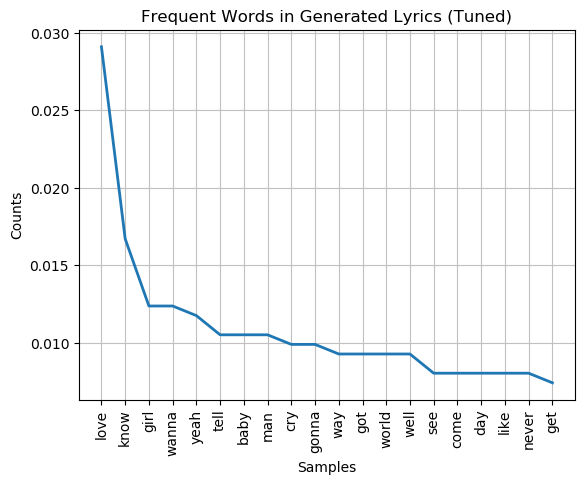

In [75]:
dist_tuned = nltk.FreqDist(all_tuned_preds_str_no_stop)
for word, count in dist_tuned.items():
    dist_tuned[word]= count/len(all_tuned_preds_str_no_stop)
filter_words = dict([(m, n) for m, n in dist_tuned.items() if len(m) > 2])
dist_tuned = nltk.FreqDist(filter_words)
dist_tuned.plot(20, cumulative=False);
plt.title('Frequent Words in Generated Lyrics (Tuned)');

### Percentages of top words
We calculate the percent of the most frequent 30 words in actual lyrics that are also present in model-generated lyrics

In [76]:
# sort each frequency dictionary to get top words for each model
sorted_actual = [name for name, count in sorted(dist_actual.items(), reverse=True, key=lambda x:x[1])]
sorted_tuned = [name for name, count in sorted(dist_tuned.items(), reverse=True, key=lambda x:x[1])]
sorted_naive = [name for name, count in sorted(dist_naive.items(), reverse=True, key=lambda x:x[1])]
sorted_naive[:10]

['love',
 'girl',
 'like',
 'please',
 'want',
 'time',
 'well',
 'never',
 'forget',
 'man']

In [77]:
# count number of top 30 words that are present in predicted text
num_top_words_naive = 0
num_top_words_tuned = 0
for top_word in sorted_actual[:30]:
    if top_word in sorted_tuned[:30]:
        num_top_words_tuned+=1
    if top_word in sorted_naive[:30]:
        num_top_words_naive+=1


In [78]:
print(f"Naive model's predictions contain {round(num_top_words_naive/30,2)}% of the top 30 words from Beatles lyrics")
print(f"Tuned model's predictions contain {round(num_top_words_tuned/30,2)}% of the top 30 words from Beatles lyrics")

Naive model's predictions contain 0.53% of the top 30 words from Beatles lyrics
Tuned model's predictions contain 0.63% of the top 30 words from Beatles lyrics


We observe that the tuned model contains a higher percentage of the most frequent words used in actual Beatles song lyrics.
## Free Text Generation
We generate text samples using each model with an open-ended prompt, toggling the Temperature parameter to determine an optimal balance between exploration and exploitation
### Naive Model Predictions

In [82]:
# Temp .3
output = naive_model("I am going", max_length=100, num_return_sequences=1, temperature=.3)[0]['generated_text']
print(output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am going to make sure that the people who have been affected by this are given the opportunity to have their voices heard."

The committee's report is expected to be released in the next few weeks.


In [83]:
# Temp 1.0
output = naive_model("I am going", max_length=100, num_return_sequences=1, temperature=1.0)[0]['generated_text']
print(output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am going to start reading them now and don't worry, I'm not about to stop." He said as he picked up the books. "I haven't decided yet which one I'm going to read or if I'm going to stick with this one, you really should have this book, this is one hell of an action story."

"I wish we could see the movie of the same title," Ruby mumbled. He smirked and added, "But I have a feeling


In [84]:
# Temp 2.0
output = naive_model("I am going", max_length=100, num_return_sequences=1, temperature=2.0)[0]['generated_text']
print(output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am going crazy!" said Mrs Fyler again. Mrs Marston's head rose as soon as the door unlocked but it was quickly locked tight again, even more tightly. When all was done, this was their last surprise and all hell to hold, Mrs Marston just gave an exclamation of 'Good evening', while her companion dropped the telephone back into Ms Avelridge's hands.
 "But I said I was coming along" cried she, turning herself into an iron arch,


In [85]:
# Temp 3.0
output = naive_model("I am going", max_length=100, num_return_sequences=1, temperature=3.0)[0]['generated_text']
print(output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am going," is really quite simple: just do not eat at your current or your former job after four, what we'd consider good hygiene days." -- Bill O'Sheff

When asked to say who were three qualities in the U.S. for whom an eating plan should fit – how the U. "No person working for themselves," not under a union would actually satisfy O'Neill in keeping those hours a person with work requirements who did most work could work those times at


### Finetuned Model Predictions

In [100]:
# Temp 0.3
output = generate_text('saved_model', "I am going", 100, temp=.3)
print(output)

I am going to get you, I am going to get you in the end Yes I am going to get you in the end Oh yeah, oh yeah I think about you night and day I need you and it's true When I think about you, I can say I'm never, never, never, never blue So I'm telling you, my friend That I'll get you, I'm going to get you in the end Yes I am going to get you in the end Oh yeah,


In [102]:
# Temp 1.0
output = generate_text('saved_model', "I am going", 100, temp=1.0)
print(output)

I am going to Kansas City for the All American CrabFest') And I get to the top of the slide And I see this big old blue taxman sitting there Taxman! I get to my feet Taxman, taxman! Woo taxman! Woo taxman! And he licks my finger Woo taxman, taxman! Woo taxman!  There were bells on a hill But I never heard them ringing No, I never heard them at all Till there was you There were birds


In [101]:
# Temp 2.0
output = generate_text('saved_model', "I am going", 100, temp=2.0)
print(output)

I am going to get 'em,'" he says matter-of-factly "You better leave me alone." And he goes And he never returns
 and he never even says goodbye As I'm sitting here doing nothing but aging (Agh) The men of my generation slither while their horses are genie-literati (Float down stream) The younger generation flies at the sun (Birthday cake) While my mother tongue is dying From aging (Ooh) Forever on end (Ah


In [109]:
# Temp 3.0
output = generate_text('saved_model', "I am going", 100, temp=3.0)
print(output)

I am going to leave Memphis, Tennessee Because..." Oh now I've found my calling here in Amarillo, Texas Here I can morn in blue all night long I can hear the games in the park Before the bus arrives Everybody says the jukebox will never drop They're damn near bullshitting Yeah! Singingbirds singing songs in a canteen Speaking Tamil in between texters Eating bacon alone in the hope it brings happiness Please, just come on me I don't care if there's


We observe that the naive model generates coherent text, but it does not follow the rhythmic pattern of a song, and appears to be an excerpt from a story.<br>
At the lowest temperature, the tuned model generates text identical to that of the Beatles song I'll Get You.<br>
At a temperature of 1.0, the trained model generates lyrics reminiscent of the Beatles song Taxman, though many of the words are changed.<br>
The remaining two predictions at temperatures 2.0 and 3.0 do not appear to resemble any specific Beatles song, though rhythmically and in subject-matter, they do appear to have similarities.